## Predicting requests using XGBoost

We have click data of properties at various dates and we need to predict the number of clicks after certain dates post property goes live on the portal.

In [165]:
#!/usr/bin/env python3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import re

import xgboost as xgb
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [166]:
# Creating dataframe from property_data_set.csv
data = pd.read_csv('resources/property_data_set.csv',parse_dates = ['activation_date'], 
                   infer_datetime_format = True, dayfirst=True)

#Fixing view options for pandas
pd.set_option('max_columns', 40)
pd.set_option('max_rows', 10)
data.head(n=10)

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type
0,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP
1,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP
2,ff808081470c645401470fb03f5800a6,BHK2,2017-03-10 13:43:00,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,ANYONE,1,GM Palya,FOUR_WHEELER,0,1200,0,560075.0,15000,75000,AP
3,ff808081470c6454014715eaa5960281,BHK3,2017-03-09 22:16:00,2,3,4.0,SEMI_FURNISHED,0,12.888169,77.591282,ANYONE,0,Arakere,BOTH,1,1300,0,560076.0,17000,150000,AP
4,ff808081474aa867014771a0298f0aa6,BHK1,2017-03-15 18:29:00,1,1,2.0,SEMI_FURNISHED,0,12.990243,77.712962,ANYONE,0,Hoodi,BOTH,4,450,0,560048.0,6500,40000,IF
5,ff8080814780f30801478d14132f03f4,BHK3,2017-03-23 16:13:00,2,2,2.0,SEMI_FURNISHED,1,12.936557,77.558291,ANYONE,0,Banashankari,TWO_WHEELER,8,1200,1,560050.0,17500,200000,IF
6,ff8080814780f308014797c79000082e,BHK2,2017-03-06 21:30:00,1,1,3.0,SEMI_FURNISHED,1,12.930229,77.633311,BACHELOR,1,Koramangala,TWO_WHEELER,5,600,1,560034.0,20000,100000,IF
7,ff80808147a95f0a0147ab0d88fa0080,BHK2,2017-03-05 18:12:00,2,0,5.0,SEMI_FURNISHED,1,12.992509,77.658957,ANYONE,1,Bennigana Halli,BOTH,18,800,1,560016.0,18000,120000,AP
8,ff80808147ac6af10147afc279480099,BHK3,2017-02-07 14:05:00,3,0,2.0,SEMI_FURNISHED,1,12.979944,77.538875,FAMILY,0,Vijayanagar,BOTH,15,2000,1,560040.0,25000,250000,IF
9,ff80808147cbdc2a0147cf8577880153,BHK2,2017-03-12 11:21:00,1,1,2.0,NOT_FURNISHED,1,12.958654,77.717208,ANYONE,0,Kundalahalli,TWO_WHEELER,8,600,0,560037.0,12000,40000,AP


In [167]:
data.describe()

,bathroom,floor,total_floor,gym,latitude,longitude,lift,property_age,property_size,swimming_pool,pin_code,rent,deposit
count,28888.000000,28888.000000,28845.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,2.856300e+04,28888.000000,2.888800e+04
mean,1.795867,1.786659,3.518807,0.165951,12.957859,77.605186,0.279009,4.380539,966.338999,0.142585,5.615600e+05,14430.768797,1.233257e+05
std,0.778676,2.361768,3.362536,0.372043,0.219500,0.921003,0.448520,7.458914,619.390016,0.349655,8.979452e+04,9055.133718,1.255028e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1000.000000,0.000000e+00
25%,1.000000,0.000000,2.000000,0.000000,12.906324,77.563295,0.000000,0.000000,600.000000,0.000000,5.600400e+05,8000.000000,5.000000e+04
50%,2.000000,1.000000,3.000000,0.000000,12.953939,77.614568,0.000000,3.000000,900.000000,0.000000,5.600670e+05,12500.000000,1.000000e+05
75%,2.000000,2.000000,4.000000,0.000000,13.009369,77.669235,1.000000,6.000000,1200.000000,0.000000,5.600840e+05,18000.000000,1.500000e+05
max,22.000000,123.000000,38.000000,1.000000,21.176277,80.256293,1.000000,800.000000,40000.000000,1.000000,5.601000e+06,75000.000000,4.200000e+06


In [168]:
#Checking which fields contain empty values
pd.isnull(data).sum()

property_id          0
type                 0
activation_date      0
bathroom             0
floor                0
                  ... 
swimming_pool        0
pin_code           325
rent                 0
deposit              0
building_type       79
dtype: int64

In [169]:
pics = pd.read_table('resources/property_photos.tsv')
pics.head()

,property_id,photo_urls
0,ff808081469fd6e20146a5af948000ea,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006..."
1,ff8080814702d3d10147068359d200cd,NaN
2,ff808081470c645401470fb03f5800a6,"[{\title\"":\""Bedroom\"",\""name\"":\""ff808081470c..."
3,ff808081470c6454014715eaa5960281,"[{\title\"":\""Bedroom\"",\""name\"":\""Screenshot_7..."
4,ff808081474aa867014771a0298f0aa6,"[{\title\"":\""Other\"",\""name\"":\""ff808081474aa8..."


In [170]:
#Trying out how to correct the json
row = pics['photo_urls'][2]
row = row.replace("\\","").replace("]\"","]").replace("{title","{\"title")
json.loads(row)

[{'displayPic': True,
  'imagesMap': {'large': 'ff808081470c645401470fb03f5800a6_46868_large.jpg',
   'medium': 'ff808081470c645401470fb03f5800a6_46868_medium.jpg',
   'original': 'ff808081470c645401470fb03f5800a6_46868_original.jpg',
   'thumbnail': 'ff808081470c645401470fb03f5800a6_46868_thumbnail.jpg'},
  'name': 'ff808081470c645401470fb03f5800a6_1968_large.jpg',
  'title': 'Bedroom'},
 {'displayPic': False,
  'imagesMap': {'large': 'ff808081470c645401470fb03f5800a6_96389_large.jpg',
   'medium': 'ff808081470c645401470fb03f5800a6_96389_medium.jpg',
   'original': 'ff808081470c645401470fb03f5800a6_96389_original.jpg',
   'thumbnail': 'ff808081470c645401470fb03f5800a6_96389_thumbnail.jpg'},
  'name': 'ff808081470c645401470fb03f5800a6_95169_large.jpg',
  'title': 'Balcony'},
 {'displayPic': False,
  'imagesMap': {'large': 'ff808081470c645401470fb03f5800a6_2023_large.jpg',
   'medium': 'ff808081470c645401470fb03f5800a6_2023_medium.jpg',
   'original': 'ff808081470c645401470fb03f5800a6_2

In [171]:
#Finding number of pics in json
len(re.findall(r'title', row))

12

In [172]:
# Creating column num_pics which will be used to store value of number of pics
pics['num_pics'] = 0
pics.head()

,property_id,photo_urls,num_pics
0,ff808081469fd6e20146a5af948000ea,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006...",0
1,ff8080814702d3d10147068359d200cd,NaN,0
2,ff808081470c645401470fb03f5800a6,"[{\title\"":\""Bedroom\"",\""name\"":\""ff808081470c...",0
3,ff808081470c6454014715eaa5960281,"[{\title\"":\""Bedroom\"",\""name\"":\""Screenshot_7...",0
4,ff808081474aa867014771a0298f0aa6,"[{\title\"":\""Other\"",\""name\"":\""ff808081474aa8...",0


In [173]:
#looping over the pics dataframe and correct photo_urls json, find number of pics in it and store it in num_pics
for index, row in pics.iterrows():
    json = row['photo_urls']
    if type(json) is str:
        correct_json = json.replace("\\","").replace("]\"","]").replace("{title","{\"title")
        pics.set_value(index, 'photo_urls', correct_json)
        n = len(re.findall(r'title', correct_json))
        pics.set_value(index, 'num_pics', n)

pics.head()

,property_id,photo_urls,num_pics
0,ff808081469fd6e20146a5af948000ea,"[{""title"":""Balcony"",""name"":""IMG_20131006_12083...",7
1,ff8080814702d3d10147068359d200cd,NaN,0
2,ff808081470c645401470fb03f5800a6,"[{""title"":""Bedroom"",""name"":""ff808081470c645401...",12
3,ff808081470c6454014715eaa5960281,"[{""title"":""Bedroom"",""name"":""Screenshot_7.jpg"",...",9
4,ff808081474aa867014771a0298f0aa6,"[{""title"":""Other"",""name"":""ff808081474aa8670147...",7


In [174]:
# Reading property_interactions.csv
interactions = pd.read_csv('resources/property_interactions.csv',  
                           parse_dates = ['request_date'], infer_datetime_format = True, 
                           dayfirst=True)
interactions.head(n=10)

,property_id,request_date
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34
1,ff808081469fd6e20146a5af948000ea,2017-03-09 15:51:17
2,ff808081469fd6e20146a5af948000ea,2017-03-10 17:30:22
3,ff808081469fd6e20146a5af948000ea,2017-03-11 17:48:46
4,ff8080814702d3d10147068359d200cd,2017-03-30 19:59:15
5,ff8080814702d3d10147068359d200cd,2017-03-13 00:18:47
6,ff8080814702d3d10147068359d200cd,2017-03-18 22:54:01
7,ff8080814702d3d10147068359d200cd,2017-03-14 19:04:26
8,ff8080814702d3d10147068359d200cd,2017-03-18 13:38:11
9,ff8080814702d3d10147068359d200cd,2017-03-28 09:57:10


In [175]:
# Adding num_pics to 'data' dataframe
result = pd.concat([data, pics['num_pics']], axis=1)
result.head()

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type,num_pics
0,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7
1,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,0
2,ff808081470c645401470fb03f5800a6,BHK2,2017-03-10 13:43:00,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,ANYONE,1,GM Palya,FOUR_WHEELER,0,1200,0,560075.0,15000,75000,AP,12
3,ff808081470c6454014715eaa5960281,BHK3,2017-03-09 22:16:00,2,3,4.0,SEMI_FURNISHED,0,12.888169,77.591282,ANYONE,0,Arakere,BOTH,1,1300,0,560076.0,17000,150000,AP,9
4,ff808081474aa867014771a0298f0aa6,BHK1,2017-03-15 18:29:00,1,1,2.0,SEMI_FURNISHED,0,12.990243,77.712962,ANYONE,0,Hoodi,BOTH,4,450,0,560048.0,6500,40000,IF,7


In [176]:
# Adding interactions dataframe to 'data' dataframe
final = pd.merge(result, interactions, on ='property_id')
final.head()

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type,num_pics,request_date
0,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7,2017-03-10 17:42:34
1,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7,2017-03-09 15:51:17
2,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7,2017-03-10 17:30:22
3,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7,2017-03-11 17:48:46
4,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,0,2017-03-30 19:59:15


In [177]:
# Creating date_diff column which tells you about the difference in date between activation and request
final['date_diff'] = (final['request_date'] - final['activation_date'])/np.timedelta64(1, 'D')
final = final.sort_values(['property_id','date_diff'], ascending=[True,True])
final.head(n=10)

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type,num_pics,request_date,date_diff
1,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7,2017-03-09 15:51:17,0.052280
2,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7,2017-03-10 17:30:22,1.121088
0,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7,2017-03-10 17:42:34,1.129560
3,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7,2017-03-11 17:48:46,2.133866
15,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,0,2017-03-08 13:53:11,1.077211
14,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,0,2017-03-08 21:04:23,1.376655
10,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,0,2017-03-08 22:30:59,1.436794
11,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,0,2017-03-10 19:13:04,3.299352
5,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,0,2017-03-13 00:18:47,5.511655
7,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,0,2017-03-14 19:04:26,7.293356


In [178]:
# Adding req_till_date which tells you about the request made till that date
final['temp'], interactions['req_till_date'] = 1, 0
final['req_till_date'] = final.groupby(['property_id'])['temp'].apply(lambda x: x.cumsum())
final = final.drop('temp', 1)
final = final.sort_values(['property_id','date_diff'], ascending=[True,True])
# final['weekday'] = final['request_date'].dt.dayofweek #Tried adding weekday but had negative effect on R2
final.head()

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type,num_pics,request_date,date_diff,req_till_date
1,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7,2017-03-09 15:51:17,0.052280,1
2,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7,2017-03-10 17:30:22,1.121088,2
0,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7,2017-03-10 17:42:34,1.129560,3
3,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7,2017-03-11 17:48:46,2.133866,4
15,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,0,2017-03-08 13:53:11,1.077211,1


In [179]:
#Printing unique values in every feature so that we can select the features to keep. 
for column in final.columns:    
    print('\n%s types: %s' %(column,len(getattr(final, column).unique())))
    print('%s: %s' %(column,getattr(final, column).unique())) 


property_id types: 22779
property_id: ['ff808081469fd6e20146a5af948000ea' 'ff8080814702d3d10147068359d200cd'
 'ff808081470c645401470fb03f5800a6' ..., 'ff8081815b1fdda8015b2000369205fd'
 'ff8081815b200540015b20158b0103c9' 'ff8081815b2007fc015b201c77a20395']

type types: 6
type: ['BHK2' 'BHK3' 'BHK1' 'RK1' 'BHK4' 'BHK4PLUS']

activation_date types: 15773
activation_date: ['2017-03-09T14:36:00.000000000' '2017-03-07T12:02:00.000000000'
 '2017-03-10T13:43:00.000000000' ..., '2017-03-30T21:47:00.000000000'
 '2017-03-30T22:30:00.000000000' '2017-03-30T22:33:00.000000000']

bathroom types: 11
bathroom: [ 1  2  3  4  5  6  0  7 21 10 20]

floor types: 27
floor: [  3   4   0   1   2   6   8   7   5   9  10  14  17  11  12  16  15  13
  18  27  20  19  21 123  26  24  22]

total_floor types: 34
total_floor: [  4.  11.   2.   3.   5.  12.   1.   0.   9.   6.  nan  10.  14.  13.   7.
  20.  17.  19.   8.  18.  15.  26.  23.  16.  21.  27.  24.  29.  22.  28.
  25.  32.  38.  30.]

furnishing type

### Feature selection
Features having too many unique values will have to be dropped. <br>

Also, features which do not help are dropped.  <br>
Dropped features: <br>
latitude, longitude, property_id, activation_date, locality, request_date, pin_code <br>

In [180]:
#Cleaning data and removing unnecessary columns
final = final.dropna()  #removing all rows having na
final = final[final.bathroom <=7] #removing rows having incorrect values of bathroom
final = final[final.property_age <=80] #removing rows having incorrect values of propert_age

#Dropping some unnecessary features
final = final.drop(['latitude','longitude','property_id','activation_date','locality','request_date','pin_code'], 1)

final.head()

,type,bathroom,floor,total_floor,furnishing,gym,lease_type,lift,parking,property_age,property_size,swimming_pool,rent,deposit,building_type,num_pics,date_diff,req_till_date
1,BHK2,1,3,4.0,SEMI_FURNISHED,1,FAMILY,1,BOTH,2,850,1,12000,120000,AP,7,0.052280,1
2,BHK2,1,3,4.0,SEMI_FURNISHED,1,FAMILY,1,BOTH,2,850,1,12000,120000,AP,7,1.121088,2
0,BHK2,1,3,4.0,SEMI_FURNISHED,1,FAMILY,1,BOTH,2,850,1,12000,120000,AP,7,1.129560,3
3,BHK2,1,3,4.0,SEMI_FURNISHED,1,FAMILY,1,BOTH,2,850,1,12000,120000,AP,7,2.133866,4
15,BHK2,2,4,11.0,SEMI_FURNISHED,1,FAMILY,1,BOTH,1,1233,1,20000,150000,AP,0,1.077211,1


In [181]:
#Checking if everything seems alrigth
for column in final.columns:    
    print('\n%s types: %s' %(column,len(getattr(final, column).unique())))
    print('%s: %s' %(column,getattr(final, column).unique())) 


type types: 6
type: ['BHK2' 'BHK3' 'BHK1' 'RK1' 'BHK4' 'BHK4PLUS']

bathroom types: 8
bathroom: [1 2 3 4 5 6 0 7]

floor types: 27
floor: [  3   4   0   1   2   6   8   7   5   9  14  10  17  11  12  16  15  13
  18  27  20  19  21 123  26  24  22]

total_floor types: 33
total_floor: [  4.  11.   2.   3.   5.  12.   1.   0.   9.   6.  10.  14.  13.   7.  17.
  19.   8.  18.  15.  20.  26.  23.  16.  21.  27.  24.  29.  22.  28.  25.
  32.  38.  30.]

furnishing types: 3
furnishing: ['SEMI_FURNISHED' 'NOT_FURNISHED' 'FULLY_FURNISHED']

gym types: 2
gym: [1 0]

lease_type types: 4
lease_type: ['FAMILY' 'ANYONE' 'BACHELOR' 'COMPANY']

lift types: 2
lift: [1 0]

parking types: 4
parking: ['BOTH' 'FOUR_WHEELER' 'TWO_WHEELER' 'NONE']

property_age types: 42
property_age: [ 2  1  0  4  8  5 18 15 20 10  9  3  6  7 12 25 13 30 40 11 16 17 50 14 22
 24 19 28 35 23 21 27 70 45 34 80 60 29 26 55 33 42]

property_size types: 1086
property_size: [ 850 1233 1200 ..., 2115 1157   30]

swimming_pool 

In [182]:
#Adding dummy variables for categorical variables
cat_variables = ['type', 'furnishing', 'lease_type', 'parking', 'building_type']

for var in cat_variables:
    dummies = pd.get_dummies(getattr(final, var), prefix=var).iloc[:, :]
    final = pd.concat([final, dummies], axis=1)
    final = final.drop(var, 1)
    print('Dummy variables created for',var)
    
final

Dummy variables created for type
Dummy variables created for furnishing
Dummy variables created for lease_type
Dummy variables created for parking
Dummy variables created for building_type


,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,num_pics,date_diff,req_till_date,type_BHK1,type_BHK2,type_BHK3,type_BHK4,type_BHK4PLUS,type_RK1,furnishing_FULLY_FURNISHED,furnishing_NOT_FURNISHED,furnishing_SEMI_FURNISHED,lease_type_ANYONE,lease_type_BACHELOR,lease_type_COMPANY,lease_type_FAMILY,parking_BOTH,parking_FOUR_WHEELER,parking_NONE,parking_TWO_WHEELER,building_type_AP,building_type_IF,building_type_IH
1,1,3,4.0,1,1,2,850,1,12000,120000,7,0.052280,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
2,1,3,4.0,1,1,2,850,1,12000,120000,7,1.121088,2,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
0,1,3,4.0,1,1,2,850,1,12000,120000,7,1.129560,3,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
3,1,3,4.0,1,1,2,850,1,12000,120000,7,2.133866,4,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
15,2,4,11.0,1,1,1,1233,1,20000,150000,0,1.077211,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170606,2,0,4.0,1,1,1,1550,0,24000,175000,11,3.736748,3,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
170609,2,0,4.0,1,1,1,1550,0,24000,175000,11,4.477917,4,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
170605,2,0,4.0,1,1,1,1550,0,24000,175000,11,7.299155,5,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
170608,2,0,4.0,1,1,1,1550,0,24000,175000,11,9.541829,6,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0


In [183]:
final.columns

Index(['bathroom', 'floor', 'total_floor', 'gym', 'lift', 'property_age',
       'property_size', 'swimming_pool', 'rent', 'deposit', 'num_pics',
       'date_diff', 'req_till_date', 'type_BHK1', 'type_BHK2', 'type_BHK3',
       'type_BHK4', 'type_BHK4PLUS', 'type_RK1', 'furnishing_FULLY_FURNISHED',
       'furnishing_NOT_FURNISHED', 'furnishing_SEMI_FURNISHED',
       'lease_type_ANYONE', 'lease_type_BACHELOR', 'lease_type_COMPANY',
       'lease_type_FAMILY', 'parking_BOTH', 'parking_FOUR_WHEELER',
       'parking_NONE', 'parking_TWO_WHEELER', 'building_type_AP',
       'building_type_IF', 'building_type_IH'],
      dtype='object')

Plotting attribute pairwise correlations


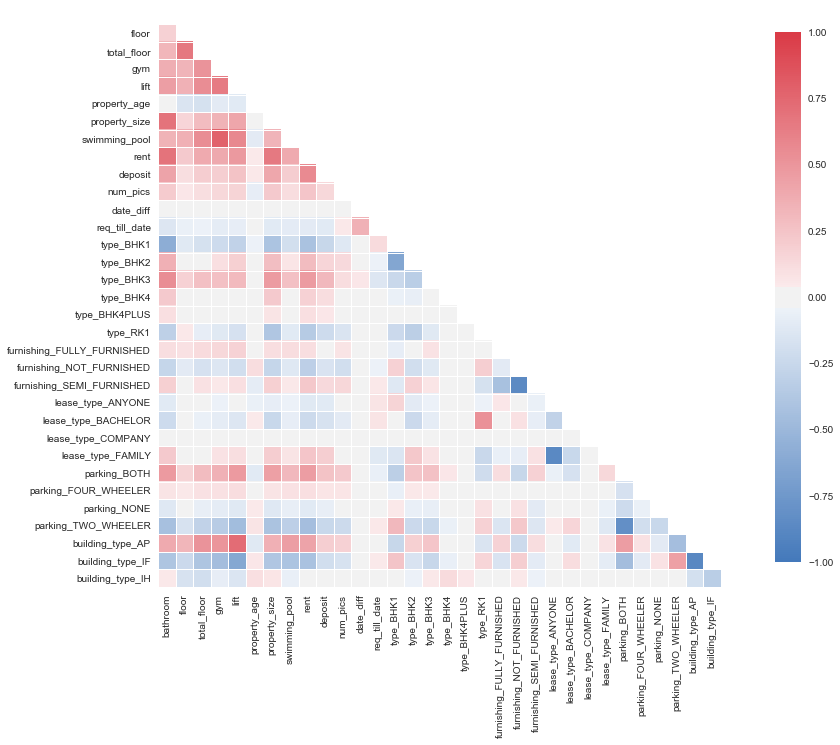

In [184]:
import logging
import seaborn as sns
import seaborn.linearmodels as snslm

def attribute_correlations(df, img_file='attr_correlations.png'):
    print('Plotting attribute pairwise correlations')

    fig, ax = plt.subplots(figsize=(13, 13))
    
    # red-blue diverging colormap with white center
    cmap = sns.diverging_palette(250, 10, n=3, as_cmap=True)
    
    # Correlation plot
    snslm.corrplot(df, ax=ax, cmap=cmap, annot=False, sig_stars=False, diag_names=False)

    plt.show()
    fig.tight_layout()
    fig.savefig(img_file)
    plt.close(fig)
    
attribute_correlations(final, img_file='attr_correlations.png')

### Correlation Analysis

We can see from the above plot that the below variables are highly correlated <br>
- gym and swimming_pool <br>
- rent and bathroom <br>
 <br>
Hence, we will be removing swimming_pool and bathroom. <br>
<b>Note</b>: It was found that removing these parameters had no deterimental 
effect on the accuracy

In [185]:
final = final.drop(['swimming_pool','bathroom'], 1)
final.shape

(169305, 31)

In [186]:
# Creating X and y
y = final['req_till_date']
X = final.drop(['req_till_date'], 1)
X.head()

,floor,total_floor,gym,lift,property_age,property_size,rent,deposit,num_pics,date_diff,type_BHK1,type_BHK2,type_BHK3,type_BHK4,type_BHK4PLUS,type_RK1,furnishing_FULLY_FURNISHED,furnishing_NOT_FURNISHED,furnishing_SEMI_FURNISHED,lease_type_ANYONE,lease_type_BACHELOR,lease_type_COMPANY,lease_type_FAMILY,parking_BOTH,parking_FOUR_WHEELER,parking_NONE,parking_TWO_WHEELER,building_type_AP,building_type_IF,building_type_IH
1,3,4.0,1,1,2,850,12000,120000,7,0.052280,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
2,3,4.0,1,1,2,850,12000,120000,7,1.121088,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
0,3,4.0,1,1,2,850,12000,120000,7,1.129560,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
3,3,4.0,1,1,2,850,12000,120000,7,2.133866,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
15,4,11.0,1,1,1,1233,20000,150000,0,1.077211,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0


In [187]:
# Scaling data 
from sklearn import preprocessing

data_scaler = preprocessing.MinMaxScaler()
target_scaler = preprocessing.MinMaxScaler()

X = data_scaler.fit_transform(X)
y = target_scaler.fit_transform(y)

y

array([ 0.        ,  0.00520833,  0.01041667, ...,  0.02083333,
        0.02604167,  0.03125   ])

In [188]:
# Splitting data into test and train
from sklearn.cross_validation import train_test_split

# Creating test data of 10% of original data
test_size=0.1

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=test_size)

print("Training and testing split was successful.")
print(X_train.shape)
print(X_test.shape)

Training and testing split was successful.
(152374, 30)
(16931, 30)



Started with Depth: 22 Estimators: 600
Model R2 score: 0.9823 at Depth: 22 Estimators: 600
True R2 score after rounding: 0.9819 at Depth: 22 Estimators: 600


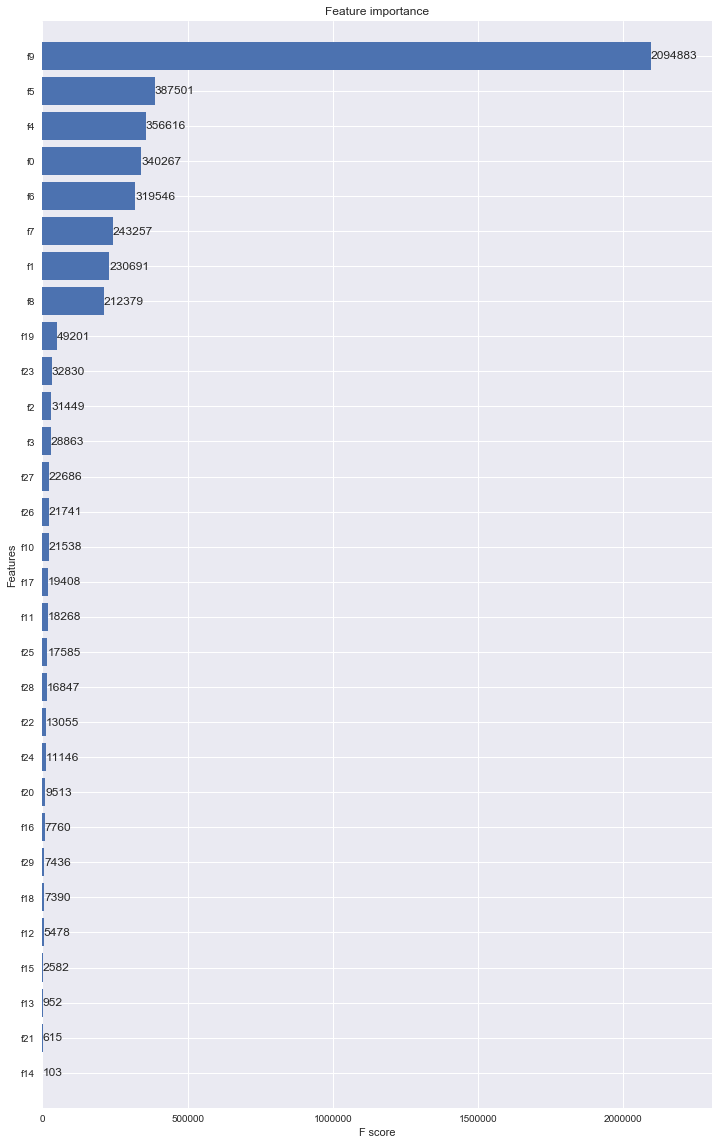

In [196]:
def xgboost(depth = 22, estimators=600, learning_rate=0.03):
    '''Our XGBoost regression model'''
    
    print("\nStarted with Depth: %s Estimators: %s" %(depth,estimators))

    model = xgb.XGBRegressor(max_depth=depth, n_estimators=estimators, learning_rate=learning_rate).fit(X_train, y_train)
    predictions_test = model.predict(X_test)
    
    # Unscaling data for checking it in csv file
    predictions_test_unscalled = np.round(target_scaler.inverse_transform(predictions_test))
    y_test_unscalled = target_scaler.inverse_transform(y_test)
    error = y_test_unscalled - predictions_test_unscalled
    
    score = metrics.r2_score(y_test, predictions_test)
    print("Model R2 score: %.4f at Depth: %s Estimators: %s" % (score , depth, estimators))
    
    actual_score = metrics.r2_score(y_test_unscalled, predictions_test_unscalled)
    print("True R2 score after rounding: %.4f at Depth: %s Estimators: %s" % (actual_score , depth, estimators))
    
    submission = pd.DataFrame({ 'True Requests': y_test_unscalled,
                                'Predicted Requests': predictions_test_unscalled, 
                                'Error': error})
    
    #Predictions saved to local path
    submission.to_csv("Predictions_d%s_e%s_RS%.4f.csv" % (depth,estimators,score), index=False)
    
    fig, ax = plt.subplots(figsize=(12,20))
    xgb.plot_importance(model, max_num_features=30, height=0.8, ax=ax)
    plt.show()

xgboost()

### Optimised hyperparameters using grid search

Started with random search and then narrowed it down to a small range

<b> max_depth</b>  = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22] <br>
<b> n_estimators</b>  = [1300, 1400, 1500, 1600, 1650, 1700, 1750] <br>
learning_rate of <b> 0.03 </b> was found to work best. <br>
 <br>
for depth in max_depth:  <br>
&nbsp;&nbsp;&nbsp;&nbsp;for estimators in n_estimators:  <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;xgboost(depth, estimators)  <br>
  <br>

R2 score: 0.9600 at Depth: 12 Estimators: 1300  <br>
R2 score: 0.9622 at Depth: 12 Estimators: 1400  <br>
R2 score: 0.9635 at Depth: 12 Estimators: 1500  <br>
R2 score: 0.9651 at Depth: 12 Estimators: 1600  <br>
R2 score: 0.9656 at Depth: 12 Estimators: 1650  <br>
R2 score: 0.9665 at Depth: 12 Estimators: 1700  <br>
R2 score: 0.9671 at Depth: 12 Estimators: 1750  <br>

R2 score: 0.9682 at Depth: 13 Estimators: 1300  <br>
R2 score: 0.9695 at Depth: 13 Estimators: 1400  <br>
R2 score: 0.9708 at Depth: 13 Estimators: 1500  <br>
R2 score: 0.9719 at Depth: 13 Estimators: 1600  <br>
R2 score: 0.9724 at Depth: 13 Estimators: 1650  <br>
R2 score: 0.9728 at Depth: 13 Estimators: 1700  <br>
R2 score: 0.9732 at Depth: 13 Estimators: 1750  <br>

R2 score: 0.9735 at Depth: 14 Estimators: 1300  <br>
R2 score: 0.9744 at Depth: 14 Estimators: 1400  <br>
R2 score: 0.9750 at Depth: 14 Estimators: 1500  <br>
R2 score: 0.9756 at Depth: 14 Estimators: 1600  <br>
R2 score: 0.9760 at Depth: 14 Estimators: 1650  <br>
R2 score: 0.9762 at Depth: 14 Estimators: 1700  <br>
R2 score: 0.9764 at Depth: 14 Estimators: 1750  <br>

R2 score: 0.9769 at Depth: 15 Estimators: 1300  <br>
R2 score: 0.9776 at Depth: 15 Estimators: 1400  <br>
R2 score: 0.9781 at Depth: 15 Estimators: 1500  <br>
R2 score: 0.9785 at Depth: 15 Estimators: 1600  <br>
R2 score: 0.9786 at Depth: 15 Estimators: 1650  <br>
R2 score: 0.9788 at Depth: 15 Estimators: 1700  <br>
R2 score: 0.9789 at Depth: 15 Estimators: 1750  <br>

R2 score: 0.9800 at Depth: 16 Estimators: 1300  <br>
R2 score: 0.9804 at Depth: 16 Estimators: 1400  <br>
R2 score: 0.9807 at Depth: 16 Estimators: 1500  <br>
R2 score: 0.9810 at Depth: 16 Estimators: 1600  <br>
R2 score: 0.9811 at Depth: 16 Estimators: 1650  <br>
R2 score: 0.9811 at Depth: 16 Estimators: 1700  <br>
R2 score: 0.9811 at Depth: 16 Estimators: 1750  <br>

R2 score: 0.9811 at Depth: 17 Estimators: 1300  <br>
R2 score: 0.9811 at Depth: 17 Estimators: 1400  <br>
R2 score: 0.9811 at Depth: 17 Estimators: 1500  <br>
R2 score: 0.9811 at Depth: 17 Estimators: 1600  <br>
R2 score: 0.9811 at Depth: 17 Estimators: 1650  <br>
R2 score: 0.9811 at Depth: 17 Estimators: 1700  <br>
R2 score: 0.9811 at Depth: 17 Estimators: 1750  <br>

R2 score: 0.9815 at Depth: 18 Estimators: 1300  <br>
R2 score: 0.9815 at Depth: 18 Estimators: 1400  <br>
R2 score: 0.9815 at Depth: 18 Estimators: 1500  <br>
R2 score: 0.9815 at Depth: 18 Estimators: 1600  <br>
R2 score: 0.9815 at Depth: 18 Estimators: 1650  <br>
R2 score: 0.9815 at Depth: 18 Estimators: 1700  <br>
R2 score: 0.9815 at Depth: 18 Estimators: 1750  <br>

R2 score: 0.9820 at Depth: 19 Estimators: 1300  <br>
R2 score: 0.9820 at Depth: 19 Estimators: 1400  <br>
R2 score: 0.9820 at Depth: 19 Estimators: 1500  <br>
R2 score: 0.9820 at Depth: 19 Estimators: 1600  <br>
R2 score: 0.9820 at Depth: 19 Estimators: 1650  <br>
R2 score: 0.9820 at Depth: 19 Estimators: 1700  <br>
R2 score: 0.9820 at Depth: 19 Estimators: 1750  <br>

R2 score: 0.9821 at Depth: 20 Estimators: 1300  <br>
R2 score: 0.9821 at Depth: 20 Estimators: 1400  <br>
R2 score: 0.9821 at Depth: 20 Estimators: 1500  <br>
R2 score: 0.9821 at Depth: 20 Estimators: 1600  <br>
R2 score: 0.9821 at Depth: 20 Estimators: 1650  <br>
R2 score: 0.9821 at Depth: 20 Estimators: 1700  <br>
R2 score: 0.9821 at Depth: 20 Estimators: 1750  <br>

R2 score: 0.9819 at Depth: 21 Estimators: 700  <br>
R2 score: 0.9819 at Depth: 21 Estimators: 1000 <br>

R2 score: 0.9821 at Depth: 22 Estimators: 500 <br>
<b>R2 score: 0.9822 at Depth: 22 Estimators: 600--> Best performer</b> <br>
R2 score: 0.9822 at Depth: 22 Estimators: 700  <br>
R2 score: 0.9822 at Depth: 22 Estimators: 800 <br>

R2 score: 0.9820 at Depth: 23 Estimators: 700 <br>

In [ ]:
# A neural network for prediction - JUST FOR FUN
from neupy import algorithms, layers
from neupy import plots
from neupy.estimators import rmsle

def neupy_model():
    
    cgnet = algorithms.ConjugateGradient(
        connection=[
            layers.Input(X_train.shape[1]),
            layers.Sigmoid(50),
            layers.Sigmoid(1),
        ],
        search_method='golden',
        show_epoch=1,
        verbose=True,
        addons=[algorithms.LinearSearch],
    )

    print("Training started")
    num = 200
    cgnet.train(X_train[:num], y_train[:num], X_test[:num], y_test[:num], epochs=5)
   
    plots.error_plot(cgnet)

    predictions_test = cgnet.predict(X_test).round(2)
    error = rmsle(target_scaler.inverse_transform(y_test),
                  target_scaler.inverse_transform(predictions_test))
    print(error)

    submission = pd.DataFrame({ 'True Requests': y_test,
                                'Predicted': predictions_test.flatten() })
    submission.to_csv("Predictions_NN.csv", index=False)

    print('Done and saved to local')

    
    
# neupy_model()